In [1]:
import torch
import numpy as np
from rect_grid import Node, GridStructure
import solve_linear as sl
import torch
import torch.nn as nn
import math
import numpy as np
import torch
import torch.nn as nn
import matplotlib.pyplot as plt

from torch.utils.data import Dataset, DataLoader
import copy


In [2]:
if not torch.cuda.is_available():
    raise RuntimeError("CUDA is not available. Please ensure a GPU is available for this run.")
print(f"Running on GPU: {torch.cuda.get_device_name(0)}")



Running on GPU: NVIDIA A100-PCIE-40GB


In [3]:
# Cell 2: SquareEITNN class (unchanged)
class SquareEITNN(nn.Module):
    def __init__(self, grid):
        super(SquareEITNN, self).__init__()
        self.grid = grid
        self.n = grid.n
        self.input_size = 8 * self.n
        self.hidden_size = self.n ** 2 + 8 * self.n
        self.output_size = self.n ** 2 + 4 * self.n
        self.interior_size = self.n ** 2
        self.neumann_copy_start = self.n ** 2 + 4 * self.n
        self.device = torch.device("cuda")

        self.W1 = nn.Parameter(torch.zeros(self.hidden_size, self.input_size, dtype=torch.float64, requires_grad=False)).to(self.device)
        self.W1_fixed = torch.zeros(self.hidden_size, self.input_size, dtype=torch.float64).to(self.device)
        self.W1_fixed_mask = torch.ones(self.hidden_size, self.input_size, dtype=torch.bool).to(self.device)
        self.W1_fixed_mask[:self.interior_size, :4*self.n] = False

        self.W1__grad = torch.zeros(self.hidden_size, self.input_size, dtype=torch.float64, requires_grad=False).to(self.device)
        self.W2__grad = torch.zeros(self.output_size, self.hidden_size, dtype=torch.float64, requires_grad=False).to(self.device)
        self._initialize_W1_blocks()
        self._initialize_W2()
    def assign_gradients(self, x_data, h, y, alpha):
        with torch.no_grad():
            batch_size = y.shape[0]
            dL_dy = torch.zeros_like(y).to(self.device)
            dL_dy[:, :self.n**2] = alpha * y[:, :self.n**2] / batch_size
            dL_dy[:, self.n**2:] = y[:, self.n**2:] / batch_size

            dW2 = dL_dy.T @ h
            grad = {}
            w2_indices = [(i, j) for i in range(self.n**2) for j in self.grid.get_node_by_index(i).neighbors if i < j < self.interior_size + 4*self.n]
            for i, j in w2_indices:
                grad[(i, j)] = dW2[i, j] + dW2[j, i] - dW2[i, i] - dW2[j, j]
                self.W2__grad[i, j] = grad[(i, j)] / (1 + self.Beta[i, j]**2)

            dW1 = self.W2_dynamic.T @ dL_dy.T @ x_data
            for i in range(self.n**2):
                for j in range(4*self.n):
                    self.W1__grad[i, j] = dW1[i, j]
    def _initialize_W1_blocks(self):
        with torch.no_grad():
            self.W1[:self.interior_size, :4*self.n] = torch.randn(self.interior_size, 4*self.n, dtype=torch.float64).to(self.device)
            self.W1[:self.interior_size, 4*self.n:] = 0.0
            self.W1_fixed[:self.interior_size, 4*self.n:] = 0.0
            self.W1[self.interior_size:self.interior_size + 4*self.n, :4*self.n] = torch.eye(4*self.n, dtype=torch.float64).to(self.device)
            self.W1_fixed[self.interior_size:self.interior_size + 4*self.n, :4*self.n] = torch.eye(4*self.n, dtype=torch.float64).to(self.device)
            self.W1[self.interior_size:self.interior_size + 4*self.n, 4*self.n:] = 0.0
            self.W1_fixed[self.interior_size:self.interior_size + 4*self.n, 4*self.n:] = 0.0
            self.W1[self.interior_size + 4*self.n:, :4*self.n] = 0.0
            self.W1_fixed[self.interior_size + 4*self.n:, :4*self.n] = 0.0
            self.W1[self.interior_size + 4*self.n:, 4*self.n:] = torch.eye(4*self.n, dtype=torch.float64).to(self.device)
            self.W1_fixed[self.interior_size + 4*self.n:, 4*self.n:] = torch.eye(4*self.n, dtype=torch.float64).to(self.device)

    def _initialize_W2(self):
        size_out = self.output_size
        size_hidden = self.hidden_size
        self.Beta = nn.Parameter(torch.zeros(size_out, size_hidden, dtype=torch.float64, requires_grad=False)).to(self.device)
        self.W2_fixed = torch.zeros(size_out, size_hidden, dtype=torch.float64).to(self.device)
        self.W2_mask = torch.ones(size_out, size_hidden, dtype=torch.bool).to(self.device)

        with torch.no_grad():
            for i in range(self.interior_size):
                node_i = self.grid.get_node_by_index(i)
                neighbor_indices = [j for j in node_i.neighbors if i < j < self.interior_size + 4*self.n]
                weights = torch.abs(torch.randn(len(neighbor_indices), dtype=torch.float64)).to(self.device)
                for k, j in enumerate(neighbor_indices):
                    self.Beta[i,j] = weights[k]
                    self.Beta[j, i] = weights[k]
                    self.W2_fixed[j, i] = weights[k]
                    self.W2_mask[i, j] = False
                self.Beta[i, i] = 0
                self.W2_fixed[i, i] = 0

            for i in range(self.interior_size + 4*self.n):
                self.Beta[i, i] = -torch.sum(torch.tensor([self.Beta[i, j] for j in range(self.interior_size + 4*self.n)], dtype=torch.float64).to(self.device))
                self.W2_fixed[i, i] = -torch.sum(torch.tensor([self.W2_fixed[i, j] for j in range(self.interior_size + 4*self.n)], dtype=torch.float64).to(self.device))

            for i in range(4*self.n):
                row = self.interior_size + i
                col = self.neumann_copy_start + i
                self.Beta[row, col] = 1.0
                self.W2_fixed[row, col] = 1.0

    def symmetrize_W2_after_training(self):
        with torch.no_grad():
            for i in range(self.interior_size):
                node_i = self.grid.get_node_by_index(i)
                neighbor_indices = [j for j in node_i.neighbors if i < j < self.interior_size + 4*self.n]
                for k, j in enumerate(neighbor_indices):
                    self.W2_fixed[i,j] = self.transform(self.Beta[i,j])
                    self.W2_fixed[j,i] = self.transform(self.Beta[i,j])
            for i in range(self.interior_size + 4*self.n):
                self.W2_fixed[i, i] = 0
                self.W2_fixed[i, i] = -torch.sum(torch.tensor([self.W2_fixed[i, j] for j in range(self.interior_size + 4*self.n)], dtype=torch.float64).to(self.device))

    def transform(self, x):
        return torch.arctan(x) + torch.pi/2

    def forward(self, x):
        self.W1_dynamic = torch.where(self.W1_fixed_mask, self.W1_fixed, self.W1).to(self.device)
        self.W2_dynamic = torch.where(self.W2_mask, self.W2_fixed, torch.arctan(self.Beta) + torch.pi/2).to(self.device)
        hid = torch.matmul(x, self.W1_dynamic.t())
        outp = torch.matmul(hid, self.W2_dynamic.t())
        return outp, hid


In [4]:
# Cell 3: generate_dtn_data (unchanged)
def generate_dtn_data(grid, batch_size):
    device = torch.device("cuda")
    dirichlet = torch.zeros((batch_size, 4*grid.n), dtype=torch.float64).to(device)
    neumann = torch.zeros((batch_size, 4*grid.n), dtype=torch.float64).to(device)

    for k in range(min(batch_size, 4*grid.n)):
        dirichlet_data = {idx: 1.0 if idx == grid.boundary_index[k] else 0.0
                          for idx in grid.boundary_index}
        potentials, neumann_data = grid.solve_forward_problem(dirichlet_data)
        dirichlet[k, k] = 1.0
        for j, idx in enumerate(grid.boundary_index):
            neumann[k, j] = neumann_data[idx]

    data = torch.cat((dirichlet, neumann), dim=1)
    return data

In [5]:
# Cell 4: loss_function (unchanged)
def loss_function(output, grid, alpha=1.0):
    device = torch.device("cuda")
    batch_size = output.size(0)
    interior = output[:, :-4*grid.n].to(device)
    boundary = output[:, -4*grid.n:].to(device)
    interior_loss = alpha * torch.sum(interior ** 2) / (2 * batch_size)
    boundary_loss = torch.sum(boundary ** 2) / (2 * batch_size)
    total_loss = interior_loss + boundary_loss
    return total_loss, interior_loss, boundary_loss

In [6]:
#adam_with_grad_clip with gradient clipping
def adam_with_grad_clip(param, grad, alpha, m_t, v_t, beta1, beta2, eps, time_step, max_grad_norm=1.0):
    device = torch.device("cuda")
    with torch.no_grad():
        if grad is None:
            grad = torch.zeros_like(param).to(device)
        # Gradient clipping
        grad_norm = torch.norm(grad, p=2)
        if grad_norm > max_grad_norm:
            grad = grad * max_grad_norm / grad_norm
        m_t1 = beta1 * m_t + (1 - beta1) * grad
        v_t1 = beta2 * v_t + (1 - beta2) * (grad ** 2)
        m_corr = m_t1 / (1 - beta1 ** time_step)
        v_corr = v_t1 / (1 - beta2 ** time_step)
        delta = alpha * m_corr / (torch.sqrt(v_corr) + eps)
        param = param - delta
        return param, m_t1, v_t1

In [7]:
class CustomCosineAnnealingWarmRestarts:
    def __init__(self, T_0, initial_lr, T_mult=1, eta_min=1e-8, eta_max_factor=0.08):
        self.T_0 = T_0  # Length of first cycle
        self.T_mult = T_mult  # Multiplier for cycle length
        self.eta_min = eta_min  # Minimum learning rate
        self.eta_max_factor = eta_max_factor  # Decay factor for max learning rate
        self.t = 0  # Current step
        self.cycle = 0  # Current cycle number
        self.T_cur = T_0  # Current cycle length
        self.base_lr = initial_lr  # Initial maximum learning rate

    def step(self):
        if self.t >= self.T_cur:  # End of cycle
            self.cycle += 1
            self.base_lr *= self.eta_max_factor  # Decay max learning rate
            self.T_cur = self.T_0 * (self.T_mult ** self.cycle)  # Update cycle length
            self.t = 0  # Reset step counter
        # Cosine annealing formula
        lr = self.eta_min + 0.5 * (self.base_lr - self.eta_min) * (1 + np.cos(np.pi * self.t / self.T_cur))
        self.t += 1
        return lr

    def reset(self, new_base_lr):
        self.base_lr = new_base_lr
        self.cycle = 0
        self.T_cur = self.T_0
        self.t = 0

In [8]:
def train_adaptive_beta_update(num_epoch, dataloader, model, alpha, learning_rate, grid, min_lr=1e-10, eta_max=0.08,
                   beta1=0.9, beta2=0.999, eps=1e-8, patience=7500, init_delta_thresh=1e-4, cycle_length=5000):
    device = torch.device("cuda")
    model.to(device)
    num_epochs = num_epoch
    loss_record = []
    interior_loss_record = []
    boundary_loss_record = []
    
    # Initialize Adam states
    adam_states = []
    model_grad = [model.W1__grad, model.W2__grad]
    model_param = [model.W1, model.Beta]
    name = ['W1', 'Beta']
    for i, (param, grad) in enumerate(zip(model_param, model_grad)):
        m_t = torch.zeros_like(param).to(device)
        v_t = torch.zeros_like(param).to(device)
        adam_states.append({'name': name[i], 'param': param, 'm': m_t, 'v': v_t, 'param_grad': grad})
    
    # Custom CosineAnnealingWarmRestarts scheduler
    scheduler = CustomCosineAnnealingWarmRestarts(T_0=cycle_length, initial_lr=learning_rate, T_mult=1, eta_min=min_lr, eta_max_factor=eta_max)
    t = 1
    best_loss = float('inf')
    best_lr = learning_rate
    epochs_since_improvement = 0
    beta1_current = beta1
    beta2_current = beta2
    beta_updated = False  # Flag to ensure beta1/beta2 update only once

    for epoch in range(num_epochs):
        total_loss_epoch = 0.0
        interior_loss_epoch = 0.0
        boundary_loss_epoch = 0.0
        num_batches = 0

        for batch_x in dataloader:
            batch_x = batch_x.to(device)
            model.zero_grad()
            output, hid = model(batch_x)
            total_loss, interior_loss, boundary_loss = loss_function(output, grid, alpha)
            model.assign_gradients(batch_x, hid, output, alpha)

            # Update parameters
            for state in adam_states:
                param = state['param']
                grad = state['param_grad']
                m = state['m']
                v = state['v']
                new_param, new_m, new_v = adam_with_grad_clip(param, grad, learning_rate, m, v, beta1_current, beta2_current, eps, t, max_grad_norm=1.0)
                param.data = new_param.data
                state['m'] = new_m
                state['v'] = new_v
            t += 1
            model.symmetrize_W2_after_training()

            total_loss_epoch += total_loss.item()
            interior_loss_epoch += interior_loss.item()
            boundary_loss_epoch += boundary_loss.item()
            num_batches += 1

        # Average losses for the epoch
        total_loss_epoch /= num_batches
        interior_loss_epoch /= num_batches
        boundary_loss_epoch /= num_batches
        loss_record.append(total_loss_epoch)
        interior_loss_record.append(interior_loss_epoch)
        boundary_loss_record.append(boundary_loss_epoch)

        # Update alpha based on loss thresholds
        min_loss = min(interior_loss_epoch, boundary_loss_epoch)
        if min_loss < 1e-9 and alpha < 1.0:
            alpha = 1.0
        elif min_loss < 1e-8 and alpha < 0.9:
            alpha = 0.9
        elif min_loss < 1e-7 and alpha < 0.8:
            alpha = 0.8

        # Update learning rate
        learning_rate = max(scheduler.step(), min_lr)

        # Reset learning rate and update beta1/beta2 if base_lr falls below 1e-7
        if scheduler.base_lr < 1e-7 and not beta_updated:
            scheduler.reset(new_base_lr=1e-4)
            learning_rate = scheduler.step()
            beta1_current = 0.95  # Increase beta1
            beta2_current = 0.9999  # Increase beta2
            beta_updated = True
            print(f"Epoch [{epoch+1}/{num_epochs}], Resetting Base LR to 1e-4, beta1 to {beta1_current}, beta2 to {beta2_current}")

        # Update init_delta_thresh based on best_loss
        if total_loss_epoch < best_loss - init_delta_thresh:
            best_loss = total_loss_epoch
            best_lr = learning_rate
            # Compute order of magnitude of best_loss
            if best_loss > 0:
                order = np.floor(np.log10(best_loss))
                init_delta_thresh = 1e-4 * 10 ** order  # 10^-4 times the order of best_loss
            # No else: if best_loss = 0, keep previous init_delta_thresh or stop
            epochs_since_improvement = 0
        elif best_loss == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss_epoch:.6e}, Stopping (best_loss = 0)")
            break
        else:
            epochs_since_improvement += 1

        # Log scheduler state
        if (epoch + 1) % 1000 == 0:
            print(f"Epoch [{epoch+1}/{num_epochs}], Total Loss: {total_loss_epoch:.6e}, Interior: {interior_loss_epoch:.6e}, Boundary: {boundary_loss_epoch:.6e}, Alpha: {alpha:.4f}, LR: {learning_rate:.6e}, Best LR: {best_lr:.6e}, Base LR: {scheduler.base_lr:.6e}, Cycle: {scheduler.cycle}, T_cur: {scheduler.T_cur}, Delta Thresh: {init_delta_thresh:.6e}, Beta1: {beta1_current:.4f}, Beta2: {beta2_current:.4f}")

        # Early stopping
        if total_loss_epoch < 1e-12:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss_epoch:.6e}, Stopping (loss < 1e-12)")
            break

        if epochs_since_improvement >= patience:
            print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {total_loss_epoch:.6e}, Stopping (no improvement)")
            break

    # Final processing
    recovered_gamma = model.W2_dynamic.detach().cpu().numpy()
    estimated_conductivities = {}
    for edge in grid.edges:
        p_idx, q_idx = edge
        if p_idx >= grid.node_count - grid.n:
            continue
        estimated_conductivities[edge] = recovered_gamma[p_idx, q_idx]

    original_conductivities = copy.deepcopy(grid.conductivities)
    print("\nConductivity Comparison Table")
    print(f"{'Edge':>10} | {'Estimated':>12} | {'True':>12}")
    print("-" * 38)
    for edge in grid.edges:
        if edge in estimated_conductivities:
            est = estimated_conductivities[edge]
            true = original_conductivities[edge]
            print(f"{str(edge):>10} | {est.item():12.6f} | {true.item():12.6f}")

    demo_grid = GridStructure(grid.n)
    demo_grid.conductivities = original_conductivities
    print("Original Conductivity")
    demo_grid.visualize_network()

    demo_grid2 = GridStructure(grid.n)
    demo_grid2.conductivities = estimated_conductivities
    print("Recovered Conductivity")
    demo_grid2.visualize_network()

    return loss_record, interior_loss_record, boundary_loss_record, estimated_conductivities

## Test Run for n = 6 by using the following features
- A cosine annealing scheduler which takes changes the learning rate every epoch from the learning rate provided (in this case 0.002) to the min_lr (in this case 1e-10)
-

In [9]:
n1 = 6
batch_size = min(4*n1, 32)  # Cap batch size
grid3_1 = GridStructure(n1)
data3_1 = generate_dtn_data(grid3_1, batch_size)
dataloader3_1 = DataLoader(data3_1, batch_size=batch_size, shuffle=True)
model3_1 = SquareEITNN(grid3_1)
alpha3_1 = 0.7
num_epoch3_1 = 30000
learning_rate3_1= 0.02
cycle_length3_1 = 5000

Epoch [1000/30000], Total Loss: 2.006162e-03, Interior: 1.008479e-03, Boundary: 9.976826e-04, Alpha: 0.7000, LR: 1.809386e-02, Best LR: 1.814885e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-07, Beta1: 0.9000, Beta2: 0.9900
Epoch [2000/30000], Total Loss: 6.041961e-04, Interior: 5.666923e-04, Boundary: 3.750380e-05, Alpha: 0.7000, LR: 1.309615e-02, Best LR: 1.325106e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-08, Beta1: 0.9000, Beta2: 0.9900
Epoch [3000/30000], Total Loss: 8.825870e-05, Interior: 7.933924e-05, Boundary: 8.919466e-06, Alpha: 0.7000, LR: 6.915806e-03, Best LR: 7.143785e-03, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-09, Beta1: 0.9000, Beta2: 0.9900
Epoch [4000/30000], Total Loss: 5.995113e-06, Interior: 3.586718e-06, Boundary: 2.408395e-06, Alpha: 0.7000, LR: 1.913525e-03, Best LR: 2.395940e-03, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-10, Beta1: 0.9000, Be

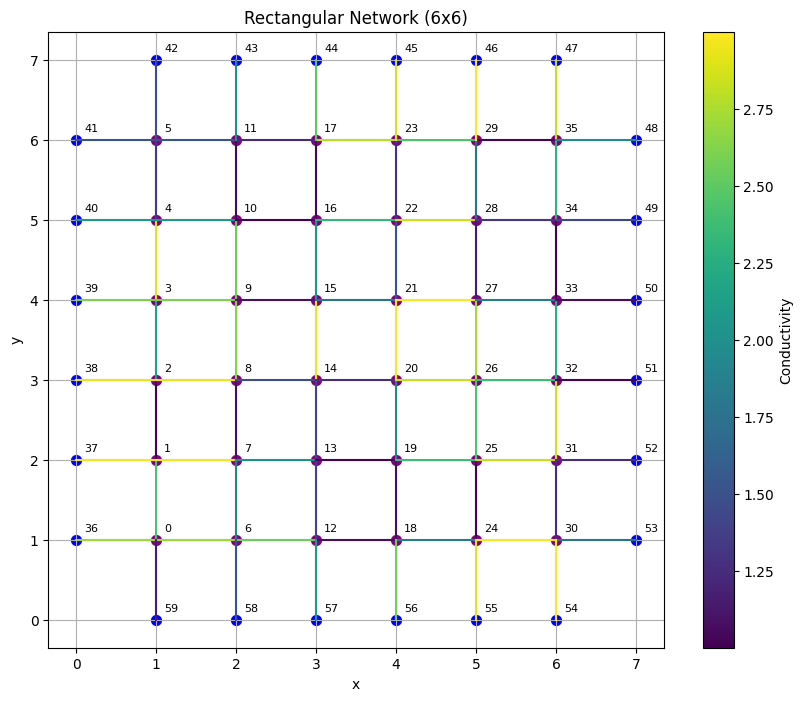

Recovered Conductivity


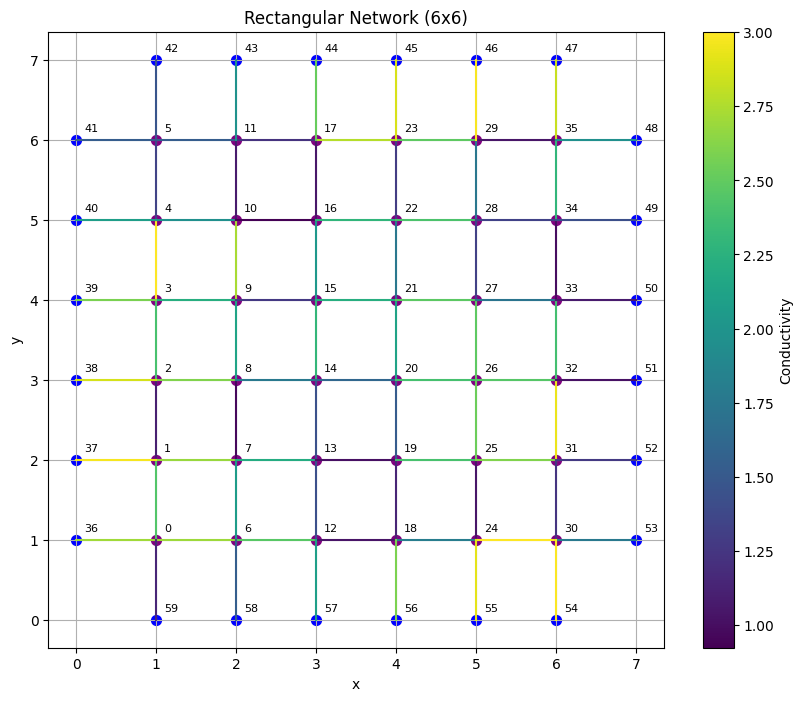

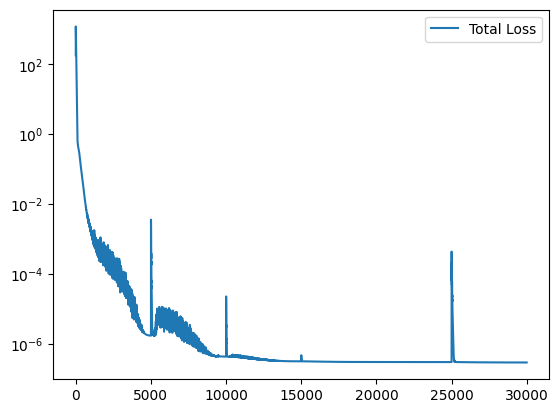

In [10]:
loss_record3_1, interior_loss, boundary_loss, estimated_conductivities = train_adaptive_beta_update(
    num_epoch3_1, dataloader3_1, model3_1, alpha3_1, learning_rate3_1, grid3_1, min_lr=1e-10, eta_max=0.08,
    beta1=0.9, beta2=0.99, eps=1e-8, patience=1.5*cycle_length3_1, init_delta_thresh=1e-4, cycle_length=cycle_length3_1
)
plt.plot(loss_record3_1, label="Total Loss")
plt.yscale("log")
plt.legend()
plt.show()

In [11]:
n1 = 6
batch_size = min(4*n1, 32)  # Cap batch size
grid3_1 = GridStructure(n1)
data3_1 = generate_dtn_data(grid3_1, batch_size)
dataloader3_1 = DataLoader(data3_1, batch_size=batch_size, shuffle=True)
model3_1 = SquareEITNN(grid3_1)
alpha3_1 = 0.7
num_epoch3_1 = 30000
learning_rate3_1= 0.02
cycle_length3_1 = 5000

Epoch [1000/30000], Total Loss: 2.306693e-03, Interior: 1.054522e-03, Boundary: 1.252170e-03, Alpha: 0.7000, LR: 1.809386e-02, Best LR: 1.811961e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-07, Beta1: 0.9000, Beta2: 0.9900
Epoch [2000/30000], Total Loss: 1.952609e-04, Interior: 1.617466e-04, Boundary: 3.351435e-05, Alpha: 0.7000, LR: 1.309615e-02, Best LR: 1.310212e-02, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-08, Beta1: 0.9000, Beta2: 0.9900
Epoch [3000/30000], Total Loss: 9.474020e-05, Interior: 8.457057e-05, Boundary: 1.016963e-05, Alpha: 0.7000, LR: 6.915806e-03, Best LR: 7.149807e-03, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-09, Beta1: 0.9000, Beta2: 0.9900
Epoch [4000/30000], Total Loss: 7.492257e-06, Interior: 4.517623e-06, Boundary: 2.974634e-06, Alpha: 0.7000, LR: 1.913525e-03, Best LR: 2.125483e-03, Base LR: 2.000000e-02, Cycle: 0, T_cur: 5000, Delta Thresh: 1.000000e-10, Beta1: 0.9000, Be

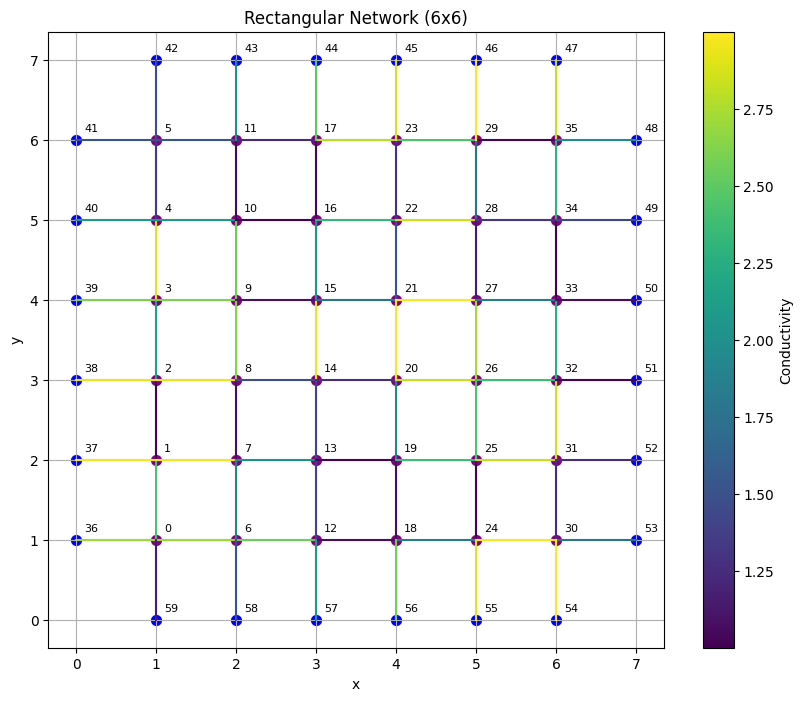

Recovered Conductivity


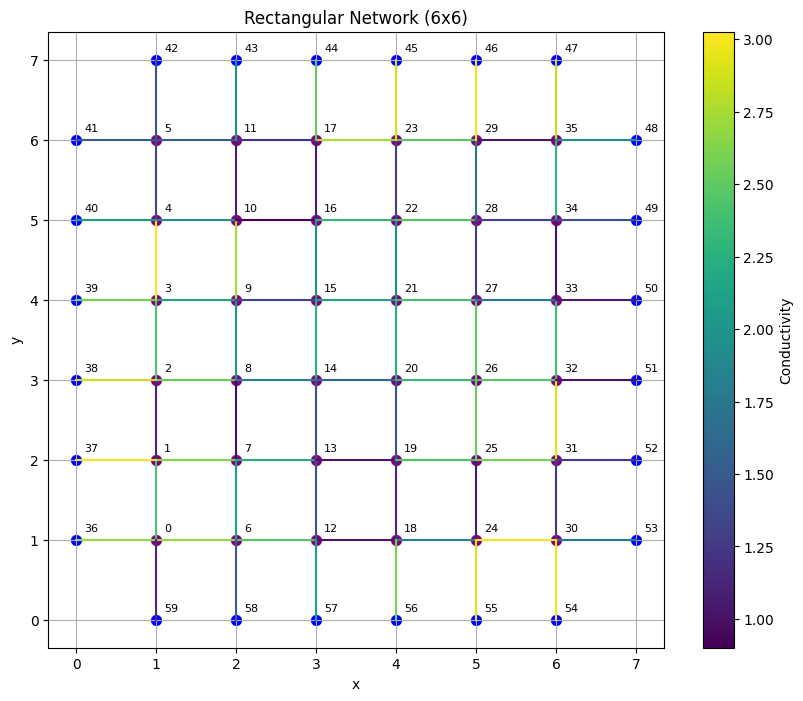

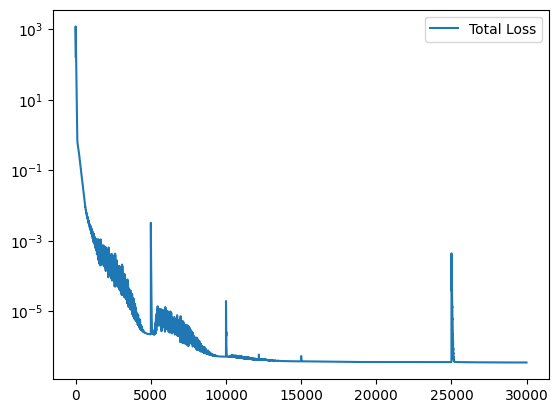

In [12]:
loss_record3_1, interior_loss, boundary_loss, estimated_conductivities = train_adaptive_beta_update(
    num_epoch3_1, dataloader3_1, model3_1, alpha3_1, learning_rate3_1, grid3_1, min_lr=1e-10, eta_max=0.08,
    beta1=0.9, beta2=0.99, eps=1e-8, patience=1.5*cycle_length3_1, init_delta_thresh=1e-4, cycle_length=cycle_length3_1
)
plt.plot(loss_record3_1, label="Total Loss")
plt.yscale("log")
plt.legend()
plt.show()